In [ ]:
'''
    @author: Ole211
    @date: 2018/8/5
    @target:
        华为官网新闻
    @detail:
        通过编写爬虫爬取华为官网新闻数据， 分析华为新闻宣传趋势
'''

# 华为官网新闻爬虫代码

In [341]:
# _*_ coding: utf-8 _*_
# @Time     : 2018/8/5 14:19
# @Author   : Ole211
# @Site     : 华为官网
# @File     : huawei.py    
# @Software : PyCharm

import requests
from bs4 import BeautifulSoup as bs
import re
from run_time import run_time as run
from setting import headers
import json
import os
import multiprocessing
import threading
import asyncio


base_url = 'https://www.huawei.com'
news_main_url = 'https://www.huawei.com/cn/press-events/news'
target_url = ['https://www.huawei.com/cn/press-events/news?d=ws&pagesize=10&pageindex={}'.format(offset) for offset in range(1, 3)]

def parse(url):
    '''
    页面解析函数
    :param url:
    :return:
    '''
    res = requests.get(url, headers=headers)
    if res.status_code == 200:
        return res.text
    return None

def get_total_count(news_main_url):
    '''
    获取新闻页面总页数
    :param news_main_url:
    :return:
    '''
    html = parse(news_main_url)
    soup = bs(html, 'html.parser')
    total_count = int(soup.find(id='span-total-count').text.strip())
    return total_count

def save_json(dic):
    '''
    保存为json 文件函数
    :param dic:
    :return:
    '''
    if dic:
        with open('d:/huaweiNews.json', 'a', encoding='utf-8') as f:
            content = json.dumps(dic, ensure_ascii=False) + '\n'
            f.write(content)
        print('Save Success')
    else:
        print('Empty data')

def get_content(news_url):
    '''
    获取页面数据
    返回一个字典
    :param news_url:
    :return:
    '''
    html = parse(news_url)
    if html:
        soup = bs(html, 'html.parser')
        dic = {}
        dic['title'] = soup.find(class_='title').find('h1').text.strip()
        dic['date'] = soup.find(class_='title').find('span').text.strip()
        dic['url'] = news_url
        div = soup.find(id='newsContent').findAll('div')
        for i in div:
            p = i.findAll('p')
            if p:
                dic['content'] = i.text
                return dic
    return None

def get_links(target_url):
    '''
    返回一个翻页页面的所有新闻链接
    :param target_url:
    :return:
    '''
    html = parse(target_url)
    if html:
        soup = bs(html, 'html.parser')
        a = soup.findAll('a', href=re.compile('^(/cn/)'))
        news_url = []
        for link in a:
            if 'href' in link.attrs:
                news_url.append(link.attrs['href'])
    return news_url



def main(offset):
    '''
    开始执行函数
    :param offset:
    :return:
    '''
    target_url = 'https://www.huawei.com/cn/press-events/news?d=ws&pagesize=10&pageindex={}'.format(offset)
    print('正在下载第%s页' % offset)
    links = get_links(target_url)
    for link in links:
        news_url = base_url + link
        dic = get_content(news_url)
        print('正在保存: %s' % news_url)
        save_json(dic)

@run
def multi_enter(n):
    '''
    1，多进程下载版本入口
    :param n:
    :return:
    '''
    processes = [multiprocessing.Process(target=main, args=(offset, )) for offset in range(1, n+1)]
    for t in processes:
        t.start()
    for t in processes:
        t.join()

@run
def thread_enter(n):
    '''
    2，多线程下载版本入口
    :param n:
    :return:
    '''
    threads = [threading.Thread(target=main, args=(offset, )) for offset in range(1, n+1)]
    for t in threads:
        t.start()
    for t in threads:
        t.join()


###################################
#      以下为异步下载部分        #

async def task(offset):
    main(offset)
    # await asyncio.sleep(1)


async def async_main(loop, n):
    tasks = [loop.create_task(task(offset)) for offset in range(1, n+1)]
    await asyncio.wait(tasks)

@run
def async_enter(n):
    '''
    3，异步下载版本入口
    :param n:
    :return:
    '''
    loop = asyncio.get_event_loop()
    loop.run_until_complete(async_main(loop, n))
    loop.close()

#             END                 #
###################################

if __name__ == '__main__':
    # if os.path.exists('d:/huaweiNews.json'):
    #     os.remove('d:/huaweiNews.json')
    #     print('删除成功')
    n = get_total_count(news_main_url)
    print(n)
    # print(type(n))
    # thread_enter(20)
#     multi_enter(n)
    # async_enter(5)



180


In [ ]:
'''
以上爬虫总共三个下载入口:
    测试结果：
        1.多进程版本：
            耗时：84s
            爬取数据：1644条
        2.多线程版本
            耗时：191s
            爬取数据：1798条（最完整）
        3.异步版本：
            耗时：最慢
            数据：不详    
  
'''

In [346]:
import json
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# 1，读取本地json文件

In [347]:
with open('d:/huaweiNews.json', 'r', encoding='utf-8', errors='ignore') as f:
    data = f.readlines()

In [349]:
len(data)

1798

# 2，通过json.loads()方法将数据转换成python 字典列表格式

In [350]:
li = []
for i in data:
    try:
        li.append(json.loads(i))
    except Exception as e:
        print(e)
        print(i)
        


In [351]:
len(li)

1798

# 3， 再转换为pandas的DataFrame 格式

In [352]:
df = pd.DataFrame(li)

In [353]:
df.date[:10]

0    2018年08月03日
1    2018年06月27日
2    2018年04月19日
3    2018年05月14日
4    2018年06月14日
5    2018年03月13日
6    2018年05月31日
7    2018年04月16日
8    2018年02月11日
9    2018年02月25日
Name: date, dtype: object

# 4，字符串日期转换为pandas日期

In [354]:
df['date'] = pd.to_datetime(df['date'], format='%Y年%m月%d日')

# 5，按日期进行排序

In [355]:
df = df.sort_values(by=['date'])

In [356]:
df.head()

,content,date,title,url
1620,\n\n\n\n\n\n[瑞典，斯德哥尔摩，2014年2月18日] 全球领先的信息与通信解决...,2014-02-18,TeliaSonera携手华为完成G.fast铜线接入方案现网试验局,https://www.huawei.com/cn/press-events/news/20...
1466,\n[中国深圳，2014年12月22日] 近日，国际电联ITU-T12月会议已正式批准G.f...,2014-12-22,华为助力ITU-T G.fast标准成功发布,https://www.huawei.com/cn/press-events/news/20...
1276,\n[芬兰，赫尔辛基，2015年1月4日] 近日，华为宣布与芬兰移动运营商Ukko Netw...,2015-01-04,华为助力芬兰Ukko Networks演示TDD LTE-A，峰值速率达507Mbps,https://www.huawei.com/cn/press-events/news/20...
1103,\n[中国，深圳，2015年1月5日] 在12月31日，“Give Me Five 奔跑吧2...,2015-01-05,华为、福建电信携手宾大，助力中国好声音广州跨年晚会,https://www.huawei.com/cn/press-events/news/20...
936,\n[中国，深圳，2015年1月5日] 近日，深圳移动携手华为，率先在其现有的4G网络中批量...,2015-01-05,规模开启载波聚合，深圳移动率先进入4G新时代,https://www.huawei.com/cn/press-events/news/20...


# 6， 数据可视化展示

In [357]:
import matplotlib.pyplot as plt
import matplotlib.font_manager
import numpy as np
% matplotlib inline

# 动态设置中文字（方法一）

In [358]:
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

# 字体管理器， 设置中文字体（方法二）

In [214]:
font = matplotlib.font_manager.FontProperties(fname='c:/windows/Fonts/SimHei.ttf')
mpl.rcParams['axes.unicode_minus'] = False  

# 2014年至2018年每年华为发布新闻数量

In [359]:
count_year = [df[(df.date>datetime(year, 1, 1)) & (df.date<datetime(year+1, 1, 1))].title.count() for year in range(2014, 2019)]

In [360]:
count_year

[2, 390, 575, 522, 309]

In [361]:
labels = ['一月', '二月', '三月', '四月', '五月', '六月', '七月', '八月', '九月', '十月', '十一月',  '十二月']

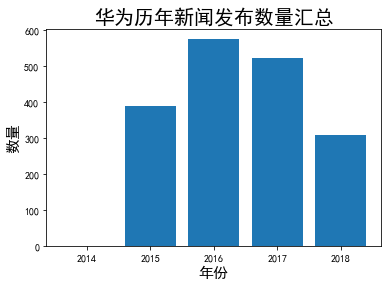

In [362]:
plt.bar(range(len(count_year)), count_year)
plt.xticks(range(len(count_year)), range(2014, 2019), fontproperties=font)
plt.title("华为历年新闻发布数量汇总", fontsize=20)
plt.xlabel('年份', fontsize=15)
plt.ylabel('数量', fontsize=15)
# plt.grid()
plt.show()

# 2014年至2018年每年以月为单位新闻发布数量

In [363]:
def get_per_month_count(year):
    li = [df[(df.date>datetime(year, month, 1)) & (df.date<datetime(year, month, 1)+timedelta(days=30))].title.count() for month in range(1, 13)]
    return li

# 历年月份数据

In [364]:
count_month = [get_per_month_count(year) for year in range(2014, 2019)]

In [365]:
count_month

[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 [20, 24, 48, 20, 35, 28, 33, 13, 46, 40, 45, 29],
 [21, 62, 40, 50, 39, 66, 28, 22, 69, 47, 71, 26],
 [12, 65, 55, 41, 32, 59, 31, 18, 78, 35, 59, 24],
 [18, 61, 48, 45, 26, 85, 21, 1, 0, 0, 0, 0]]

In [366]:
total = []
for i in count_month:
    for j in i:
        total.append(j)

# 折现图

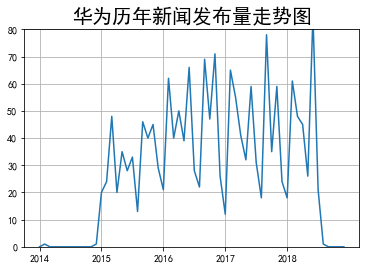

In [367]:
plt.plot(range(len(total)), total)
plt.xticks(range(0, len(total), 12), range(2014, 2019))
plt.title('华为历年新闻发布量走势图', fontsize=20)
plt.ylim(0,80)
plt.grid()
plt.show()

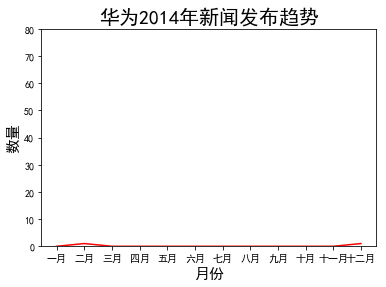

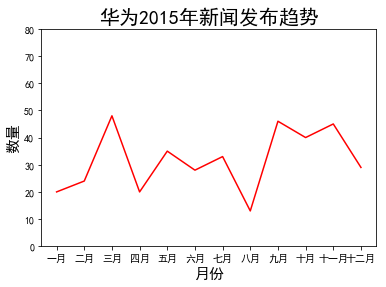

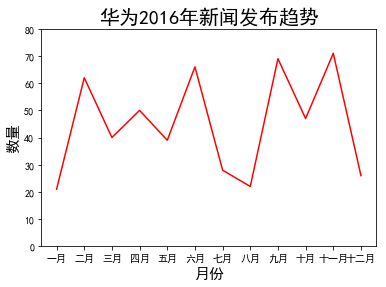

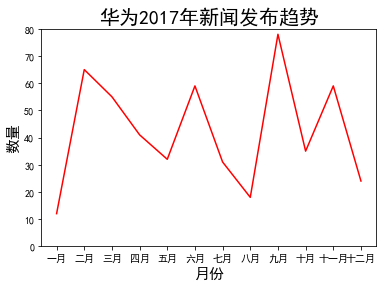

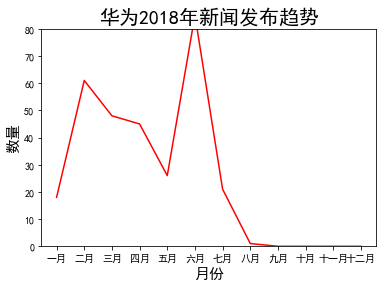

In [368]:
for i in range(5):
    plt.plot(range(12), count_month[i], color='r')
    plt.xticks(range(12), labels)
    plt.title('华为'+str(2014+i)+'年新闻发布趋势', fontsize=20)
    plt.xlabel('月份', fontsize=15)
    plt.ylabel('数量', fontsize=15)
    plt.ylim(0, 80)
    plt.show()

# 条形图

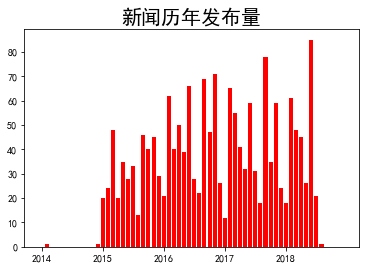

In [369]:
plt.bar(range(len(total)), total, color='r')
plt.xticks(range(0, len(total), 12), range(2014, 2019))
plt.title('新闻历年发布量', fontsize=20)
plt.show()

# 饼状图

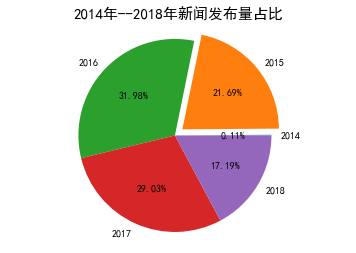

In [371]:
explode = (0, 0.1, 0, 0, 0)
plt.pie(count_year, labels=range(2014, 2019), autopct='%1.2f%%', startangle=0, explode=explode)
plt.title('2014年--2018年新闻发布量占比', fontsize=15)
plt.axis('equal')
plt.show()

# 气泡图

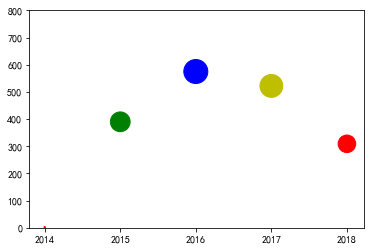

In [372]:
plt.scatter(range(len(count_year)), count_year, s=count_year, color='rgby')
plt.xticks(range(len(count_year)), range(2014, 2019))
plt.ylim(0, 800)
plt.show()

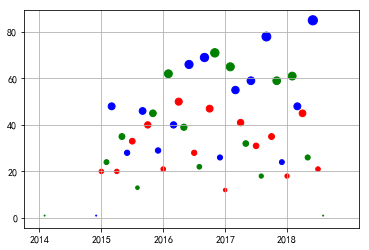

In [373]:
plt.scatter(range(len(total)),total, s=total, color='rgb')
plt.xticks(range(0,60, 12), range(2014, 2019))
plt.grid()
plt.show()

In [378]:
get_per_month_count(2015)

[20, 24, 48, 20, 35, 28, 33, 13, 46, 40, 45, 29]

# 获取三天前的日期

In [376]:
t = datetime.now()
print(t)

2018-08-05 21:34:10.446830


In [377]:
t3 = t - timedelta(days=3)
print(t3)

2018-08-02 21:34:10.446830
